## Deep Q-Network (DQN) Vs Deep Q-Network without Target
---
In this notebook, you will implement two versions of Deep Q-Learning  agent:
 - DQN with a fixed Target network
 - DQN without Target network

The two agents will be trained with OpenAI Gym's CartPole_v1 environment.

### Import the Necessary Packages

In [ ]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import imageio
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Define some hyperparameter

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define Neural Network Architecture.

Since `CartPole_v1` environment is sort of simple envs, we don't need complicated architecture. We just need non-linear function approximator that maps from state to action.

In [ ]:
class QNetwork(nn.Module):

    def __init__(self, state_shape, action_space_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_shape (int): Dimension of each state
            action_space_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_shape, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_space_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x=self.fc3(x)
        return x

### Define Replay Buffer
### Experience Replay

To perform *experience replay* the authors store the agent's experiences $e_t$ as represented by the tuple

$$ e_t = (s_t, a_t, r_t, s_{t+1}) $$

consisting of the observed state in period $t$, the reward received in period $t$, the action taken in period $t$, and the resulting state in period $t+1$. The dataset of agent experiences at period $t$ consists of the set of past experiences.

$$ D_t = \{e1, e2, ..., e_t \} $$

Depending on the task it may note be feasible for the agent to store the entire history of past experiences.

During learning Q-learning updates are computed based on samples (or minibatches) of experience $(s,a,r,s')$, drawn uniformly at random from the pool of stored samples $D_t$.

The following is my Python implmentation of these ideas.


In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Define the Deep QLearning Agent

The Deep $Q$-learning update at iteration $i$ uses the following loss function

$$ \mathcal{L_i}(\theta_i) = \mathbb{E}_{(s, a, r, s') \sim U(D)} \Bigg[\bigg(r + \gamma \max_{a'} Q\big(s', a'; \theta_i^{-}\big) - Q\big(s, a; \theta_i\big)\bigg)^2\Bigg] $$

where $\gamma$ is the discount factor determining the agent’s horizon, $\theta_i$ are the parameters of the $Q$-network at iteration $i$ and $\theta_i^{-}$ are the $Q$-network parameters used to compute the target at iteration $i$. The target network parameters $\theta_i^{-}$ are only updated with the $Q$-network parameters $\theta_i$ every $C$ steps and are held fixed between individual updates.


In [ ]:
class DQAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_shape, action_space_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_shape (int): dimension of each state
            action_space_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_shape = state_shape
        self.action_space_size = action_space_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_shape, action_space_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_shape, action_space_size, seed).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # Epsilon-greedy action selection
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            action_values = self.qnetwork_local(state)
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_space_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)

        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Define the Deep QLearning Agent Without Target Network

In [ ]:
class DQAgent_Without_Target():
    """Interacts with and learns from the environment."""

    def __init__(self, state_shape, action_space_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_shape (int): dimension of each state
            action_space_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_shape = state_shape
        self.action_space_size = action_space_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_shape, action_space_size, seed).to(device)
        # self.qnetwork_target = QNetwork(state_shape, action_space_size, seed).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # Epsilon-greedy action selection
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            action_values = self.qnetwork_local(state)
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_space_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from local network
        # q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets_next = self.qnetwork_local(next_states).detach().max(1)[0].unsqueeze(1)

        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)

        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### Training Process

The code for the training loop remains unchanged For both agents (DQN and DQN Without Target).


In [ ]:
def dqn(agent, n_episodes=2500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores


### Creating the Gym environment CartPole-v1
<img src="https://gymnasium.farama.org/_images/cart_pole.gif" alt="LunarLander-v2"  width="100%"/>

This environment is part of the Classic Control environments which contains general information about the environment.


### Description
This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

### Action Space
The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

- 0: Push cart to the left

- 1: Push cart to the right

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

### Observation Space
The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:

- Cart Position
- Cart Velocity
- Pole Angle
- Pole Angular Velocity

### Rewards
Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 500

In [ ]:

env = gym.make('CartPole-v1')
print(env.reset())
print('State shape: ', env.observation_space.shape[0])
print('Number of actions: ', env.action_space.n)


[-0.01102227  0.04606216 -0.02734247  0.00645627]
State shape:  4
Number of actions:  2


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Training the `DQagent` using  DQN


In [ ]:
DQagent = DQAgent(state_shape=env.observation_space.shape[0], action_space_size=env.action_space.n, seed=0)
scores_dqn = dqn(DQagent)

Episode 100	Average Score: 16.93
Episode 200	Average Score: 12.29
Episode 300	Average Score: 11.06
Episode 400	Average Score: 10.15
Episode 500	Average Score: 9.74
Episode 600	Average Score: 10.23
Episode 700	Average Score: 13.08
Episode 800	Average Score: 30.78
Episode 900	Average Score: 175.87
Episode 1000	Average Score: 203.02
Episode 1100	Average Score: 210.05
Episode 1200	Average Score: 207.67
Episode 1300	Average Score: 207.42
Episode 1400	Average Score: 232.25
Episode 1500	Average Score: 199.48
Episode 1600	Average Score: 176.10
Episode 1700	Average Score: 177.52
Episode 1800	Average Score: 191.46
Episode 1900	Average Score: 227.48
Episode 2000	Average Score: 231.73
Episode 2100	Average Score: 202.10
Episode 2200	Average Score: 175.00
Episode 2300	Average Score: 201.36
Episode 2400	Average Score: 207.06
Episode 2500	Average Score: 210.73


### Training the `DQagent_Without_Target` by avoiding the Target network


In [12]:
DQagent_Without_Target = DQAgent_Without_Target(state_shape=env.observation_space.shape[0], action_space_size=env.action_space.n, seed=0)
scores_dqn_without_target = dqn(DQagent_Without_Target)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100	Average Score: 21.75
Episode 200	Average Score: 69.66
Episode 300	Average Score: 252.54
Episode 400	Average Score: 274.46
Episode 500	Average Score: 190.90
Episode 600	Average Score: 444.56
Episode 700	Average Score: 322.44
Episode 800	Average Score: 67.14
Episode 900	Average Score: 9.43
Episode 1000	Average Score: 9.44
Episode 1100	Average Score: 28.34
Episode 1200	Average Score: 163.02
Episode 1300	Average Score: 194.67
Episode 1400	Average Score: 172.20
Episode 1500	Average Score: 382.19
Episode 1600	Average Score: 318.36
Episode 1700	Average Score: 25.44
Episode 1800	Average Score: 10.13
Episode 1900	Average Score: 157.21
Episode 2000	Average Score: 263.39
Episode 2100	Average Score: 15.61
Episode 2200	Average Score: 9.34
Episode 2300	Average Score: 234.40
Episode 2400	Average Score: 365.68
Episode 2500	Average Score: 312.36


##  Comparing DQN and  DQN-Without_Target
#### Plotting the time series of scores (scores_dqn & scores_dqn_without_target )

I can use [Pandas](https://pandas.pydata.org/) to quickly plot the time series of scores along with a 100 episode moving average. Note that training stops as soon as the rolling average crosses the target score.

In [13]:
scores_dqn   = pd.Series(scores_dqn , name="scores")
scores_dqn .describe()

count    2500.00000
mean      142.02240
std        94.82209
min         8.00000
25%        15.00000
50%       185.00000
75%       211.00000
max       500.00000
Name: scores, dtype: float64

In [14]:
scores_dqn_without_target   = pd.Series(scores_dqn_without_target , name="scores")
scores_dqn_without_target .describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count    2500.000000
mean      172.586400
std       178.490111
min         8.000000
25%        11.000000
50%       119.000000
75%       305.000000
max       500.000000
Name: scores, dtype: float64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


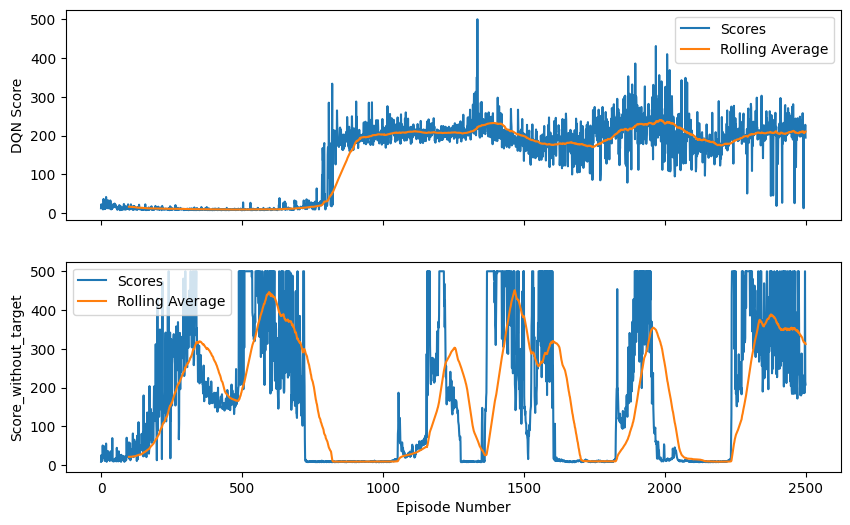

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = scores_dqn.plot(ax=ax[0], label="Scores")
_ = (scores_dqn.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax[0]))
_=ax[0].legend()
_=ax[0].set_ylabel("DQN Score")

_ = scores_dqn_without_target.plot(ax=ax[1], label="Scores")
_ = (scores_dqn_without_target.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax[1]))
_=ax[1].legend()
_ = ax[1].set_ylabel("Score_without_target")
_ = ax[1].set_xlabel("Episode Number")